# Finetuning on Fashion MNIST
The objective is to finetune a basic MLP (Multi-Layer Perceptron) from a pretrained version. These tasks would be executed by whom wants to use the pretraining performed by the attacker. Even though some flags will be used for understanding better the functioning of the latches, the attacker could recover the images of the finetuning by simply having the weights of the finetuned model. 

First, all the libraries will be imported:

In [1]:
import os
import sys
from tqdm import tqdm
from IPython.display import clear_output



import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
from safetensors.torch import save_file, load_file
import random
import numpy as np


# To add src to the path so that we can import modules
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
if not parent_directory.endswith("dataset_stealing_with_privacy_doors"):
    sys.path.append(os.path.join(current_directory, 'dataset_stealing_with_privacy_doors'))
else:
    sys.path.append(parent_directory)

try:
    from src import DATA_DIR, MODELS_DIR
except ModuleNotFoundError:
    print("Ensure that src is added to PATH and restart the kernel")
    print(sys.path)

These are the parameters used for pretraining and seed init:

In [2]:
params = {
    'batch_size':64, #changed from 64 to 256
    'eval_batch_size':64,
    'hidden_size': 256,
    'num_epochs':5,
    'num_classes':10,
    'learning_rate':1e-6,
    'log_interval':300,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 33
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

The FashionMNIST dataset is downloaded using the torchvision.datasets module. The dataset is then loaded into a DataLoader object, which is used to iterate over the dataset in batches. The Normalization performed is between 0-1 as the pretrained model recommends. 

In [3]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.FashionMNIST(root=DATA_DIR, train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=params['batch_size'], shuffle=True)
val_dataset = datasets.FashionMNIST(root=DATA_DIR, train=False, download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=params['eval_batch_size'], shuffle=False)
print("Number of images in train:",len(train_dataset))
print("Number of images in validation:",len(val_dataset))
print("Splits:", "{:.2f}".format(len(train_loader) / (len(val_loader)+len(train_loader))),
      "/","{:.2f}".format(len(val_loader) / (len(val_loader)+len(train_loader))))

Number of images in train: 60000
Number of images in validation: 10000
Splits: 0.86 / 0.14


In [4]:
# We can retrieve a sample from the dataset by simply indexing it
img, label = train_dataset[0]
print('Img shape: ', img.shape)
print('Label: ', label)

# Check if the image values are in the [0, 1] interval
assert img.min() >= 0 and img.max() <= 1, "Image values are not in the [0, 1] interval"

Img shape:  torch.Size([1, 28, 28])
Label:  9


In [5]:
# Similarly, we can sample a BATCH from the dataloader by running over its iterator
iter_ = iter(train_loader)
bimg, blabel = next(iter_)
print('Batch Img shape: ', bimg.shape)
print('Batch Label shape: ', blabel.shape)
print(f'The Batched tensors return a collection of {bimg.shape[0]} grayscale images ({bimg.shape[1]} channel, {bimg.shape[2]} height pixels, {bimg.shape[3]} width pixels)')
print(f'In the case of the labels, we obtained {blabel.shape[0]} batched integers, one per image')

# Check if the batch image values are in the [0, 1] interval
assert bimg.min() >= 0 and bimg.max() <= 1, "Batch image values are not in the [0, 1] interval"

Batch Img shape:  torch.Size([64, 1, 28, 28])
Batch Label shape:  torch.Size([64])
The Batched tensors return a collection of 64 grayscale images (1 channel, 28 height pixels, 28 width pixels)
In the case of the labels, we obtained 64 batched integers, one per image


(-0.5, 241.5, 241.5, -0.5)

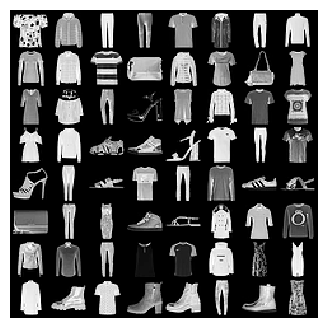

In [6]:
# make_grid is a function from the torchvision package that transforms a batch
# of images to a grid of images
img_grid = make_grid(bimg)

plt.figure(figsize = (4, 4))
plt.imshow(img_grid.permute(1, 2, 0), interpolation='nearest')
plt.axis('off')

Now a MLP class is instanciated. In theory this would be given by the pretrained model weights, and this would be modified from the MLP class used to create invisible data point latches. Keeping in mind that there are 10 classes (10 clothes) and the input size is the same, only the last layer needs to be modified by the user that wants to finetune the model. 

In [7]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(-1, 28*28) # layer 1
        x = torch.relu(self.fc1(x)) # layer 2
        x = self.fc2(x) # layer 3
        return x

The classification is reinstanciated and model wights loaded. 

In [8]:
# Initialize the model, loss function and optimizer
model = MLP(params['hidden_size'], params['num_classes'])

# Define the path to the saved model
archive_name = "model_pretrained.safetensors"
loading_path = os.path.join(MODELS_DIR, archive_name)

# Load the model state dictionary
state_dict = load_file(loading_path)
print(state_dict.keys())

# Initialize the model and load the state dictionary, remake the classifier
model.load_state_dict(state_dict)
model.fc2 = nn.Linear(params['hidden_size'], params['num_classes'])

model.to(device)
print("Model loaded successfully from", loading_path)

dict_keys(['fc1.bias', 'fc1.weight', 'fc2.bias', 'fc2.weight'])
Model loaded successfully from C:\Users\arman\Desktop\dataset_stealing_with_privacy_doors\models\model_pretrained.safetensors


In order to work, it is needed the SGD optimizer with no weight decay. 

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [10]:
def train (epoch_id, model, train_loader, device):
    model.train()
    global_epoch_loss = 0.0
    all_preds_labels = torch.empty(0, device = 'cpu')
    all_labels = torch.empty(0, device = 'cpu')
    for i, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader),
                                                    desc = f'(TRAIN)Epoch {epoch_id+1}', 
                                                    miniters=int(len(train_loader)/params['log_interval'])):
        # Forward and backward pass
        optimizer.zero_grad()
        images = images.to(device); labels = labels.to(device)
        outputs = model(images)
        predicted_label = torch.argmax(outputs, dim=1) # Get the predicted labels using argmax
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Store results
        global_epoch_loss += loss.data.item()*images.shape[0] # Accumulate the loss
        all_preds_labels = torch.cat((all_preds_labels, predicted_label.cpu())) 
        all_labels = torch.cat((all_labels, labels.cpu()))
        
        # Show the batch results every 100 batches
        if i % params['log_interval'] == 0: # Print the metrics every 100 batches
            predicted_label = torch.argmax(outputs, dim=1)
            acc_batch = torch.sum(predicted_label == labels).item()/params['batch_size']*100
            tqdm.write(f"TRAIN [{i+1}/{len(train_loader)}], Batch accuracy: {acc_batch:.3f}%; Batch Loss: {loss.item():.3f}")
    
    acc_epoch = torch.sum(all_preds_labels == all_labels).item()/len(train_loader.dataset)*100
    return model, global_epoch_loss/len(train_loader.dataset), acc_epoch

def validation (epoch_id, model,val_loader, device):
    model.eval()
    all_preds_labels = torch.empty(0, device = 'cpu')
    all_labels = torch.empty(0, device = 'cpu')
    global_epoch_loss = 0.0
    with torch.no_grad():
        for i, (images, labels) in tqdm(enumerate(val_loader), total=len(val_loader),
                                                    desc = f'(VAL)Epoch {epoch_id+1}', 
                                                    miniters=int(len(val_loader)/params['log_interval'])):
            # Forward pass
            images = images.to(device); labels = labels.to(device)
            outputs = model(images)
            predicted_label = torch.argmax(outputs, dim=1) # Get the predicted labels using argmax
            loss = criterion(outputs, labels)
            # Store results
            all_preds_labels = torch.cat((all_preds_labels, predicted_label.cpu())) 
            all_labels = torch.cat((all_labels, labels.cpu()))
            global_epoch_loss += loss.data.item()*images.shape[0] # Accumulate the loss
            
            # Show the batch results every 100 batches
            if i % params['log_interval'] == 0: # Print the metrics every 100 batches
                acc_batch = torch.sum(predicted_label == labels).item()/params['batch_size']*100
                tqdm.write(f"VAL [{i+1}/{len(train_loader)}], Batch accuracy: {acc_batch:.3f}%; Batch Loss: {loss.item():.3f}")

        acc_epoch = torch.sum(all_preds_labels == all_labels).item()/len(val_loader.dataset)*100
    return global_epoch_loss/len(val_loader.dataset), acc_epoch

In [11]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch_id in range(params['num_epochs']):
    tqdm.write(f"EPOCH {epoch_id+1} ------------------------------------")
    model, train_loss, train_acc = train(epoch_id, model, train_loader, device)
    clear_output(wait=True)
    print(f"Epoch {epoch_id+1} mean training loss: {train_loss:.4f}")
    print(f"Epoch {epoch_id+1} total training accuracy: {train_acc:.2f}%")
    val_loss, val_acc = validation(epoch_id, model,val_loader, device)
    print(f"Epoch {epoch_id+1} mean validation loss: {val_loss:.4f}")
    print(f"Epoch {epoch_id+1} total validation accuracy: {val_acc:.2f}%")
    
    # Save results
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

Epoch 5 mean training loss: 0.8827
Epoch 5 total training accuracy: 71.89%


(VAL)Epoch 5:   0%|          | 0/157 [00:00<?, ?it/s]

VAL [1/938], Batch accuracy: 64.062%; Batch Loss: 0.924


(VAL)Epoch 5: 100%|██████████| 157/157 [00:00<00:00, 361.42it/s]

Epoch 5 mean validation loss: 0.8690
Epoch 5 total validation accuracy: 71.23%


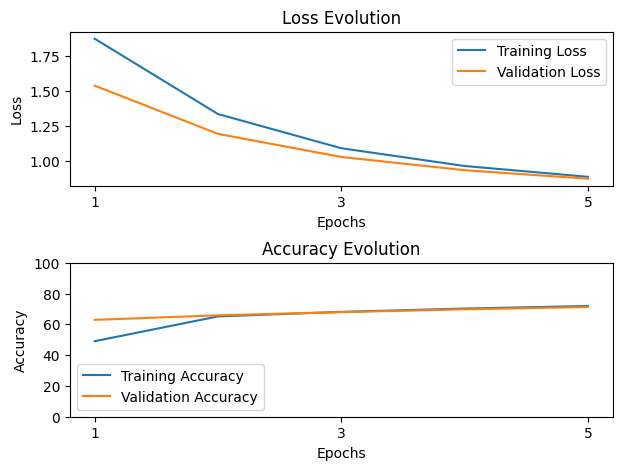

In [12]:
# Graficar la evolución de la pérdida y la precisión
plt.figure(figsize=(7, 5))

plt.subplot(2, 1, 1)
plt.plot(range(1, params['num_epochs'] + 1), train_losses, label='Training Loss')
plt.plot(range(1, params['num_epochs'] + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Evolution')
plt.legend()
plt.xticks(range(1, params['num_epochs'] + 1, 2))  # Mostrar solo enteros en el eje x


plt.subplot(2, 1, 2)
plt.plot(range(1, params['num_epochs'] + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, params['num_epochs'] + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Evolution')
plt.legend()
plt.ylim(0, 100)  # Establecer los límites del eje y entre 0 y 100%
plt.xticks(range(1, params['num_epochs'] + 1, 2))  # Mostrar solo enteros en el eje x

plt.subplots_adjust(hspace=0.5)

plt.show()

Save results using safetensors

In [13]:
archive_name = "model_finetuned.safetensors"
saving_path = os.path.join (MODELS_DIR, archive_name)
save_file(model.state_dict(), saving_path)

Make some predictions to test results:

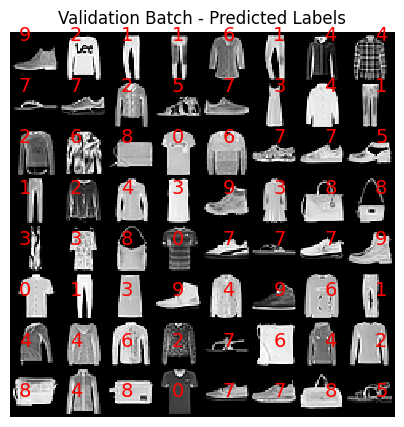

In [14]:
# Set the model to evaluation mode
model.eval()

# Get a batch of validation data
val_iter = iter(val_loader)
val_images, val_labels = next(val_iter)

# Make predictions
with torch.no_grad():
    val_images = val_images.to(device); val_labels = val_labels.to(device)
    outputs = model(val_images)
    val_images = val_images.cpu()
    _, predicted = torch.max(outputs.cpu(), 1)

# Create a grid of images
val_img_grid = make_grid(val_images)

# Plot the grid with predicted labels
plt.figure(figsize=(5, 5))
plt.imshow(val_img_grid.permute(1, 2, 0), interpolation='nearest')
plt.axis('off')
plt.title('Validation Batch - Predicted Labels')

# Annotate the images with predicted labels
for i in range(val_images.size(0)):
    plt.text(i % 8 * 32 + 5, i // 8 * 32 + 5, str(predicted[i].item()), color='red', fontsize=14)

plt.show()

It can be seen how the model works as thought.

## Finetunning with corrupted model

In [15]:
archive_name = "corrupted_positions.safetensors"
loading_path = os.path.join (MODELS_DIR, archive_name)
positions = load_file(loading_path)["positions"].int().tolist()
positions = sorted(positions)
print(positions)

[1, 13, 14, 16, 18, 30, 31, 47, 54, 59, 62, 69, 70, 71, 72, 77, 79, 81, 82, 85, 90, 93, 105, 109, 113, 122, 123, 127, 128, 131, 132, 135, 136, 142, 155, 157, 161, 162, 166, 167, 172, 173, 174, 175, 188, 190, 191, 195, 197, 207, 208, 209, 210, 214, 215, 220, 225, 228, 231, 232, 237, 243, 244, 248]


In [16]:
# Define the MLP model
class MLP_advanced(nn.Module):
    def __init__(self, hidden_size, num_classes):
        super(MLP_advanced, self).__init__()
        self.fc1 = nn.Linear(28*28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.constant = nn.Parameter(torch.ones(hidden_size, device=device))

    def forward(self, x):
        x = x.view(-1, 28*28) # layer 1
        x = torch.relu(self.constant * self.fc1(x)) # Corrupted layer 2
        x = self.fc2(x) # layer 3
        return x

Now it is loaded

In [17]:
# Initialize the model, loss function and optimizer
model_advanced = MLP_advanced(params['hidden_size'], params['num_classes'])

# Define the path to the saved model
archive_name = "model_pretrained_advanced_general.safetensors"
loading_path = os.path.join(MODELS_DIR, archive_name)

# Load the model state dictionary
state_dict = load_file(loading_path)
print(state_dict.keys())

# Initialize the model and load the state dictionary, remake the classifier
model_advanced.load_state_dict(state_dict)
model_advanced.fc2 = nn.Linear(params['hidden_size'], params['num_classes'])

print("Model loaded successfully from", loading_path)
model_advanced.to(device)

dict_keys(['constant', 'fc1.bias', 'fc1.weight', 'fc2.bias', 'fc2.weight'])
Model loaded successfully from C:\Users\arman\Desktop\dataset_stealing_with_privacy_doors\models\model_pretrained_advanced_general.safetensors


MLP_advanced(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

Change to see if any backdoored neuron fires. 

In [18]:
def train (epoch_id, model, train_loader, device, fires):
    model.train()
    global_epoch_loss = 0.0
    all_preds_labels = torch.empty(0, device = 'cpu')
    all_labels = torch.empty(0, device = 'cpu')
    for i, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader),
                                                    desc = f'(TRAIN)Epoch {epoch_id+1}', 
                                                    miniters=int(len(train_loader)/params['log_interval'])):
        # Forward and backward pass
        optimizer.zero_grad()
        images = images.to(device); labels = labels.to(device)
        outputs = model(images)
        predicted_label = torch.argmax(outputs, dim=1) # Get the predicted labels using argmax
        loss = criterion(outputs, labels)
        loss.backward()
        gradients = model.fc1.weight.grad[positions]
        if (gradients != 0).any():
            nonzero_indices = (gradients != 0).any(dim=1).nonzero(as_tuple=True)[0].tolist()
            for idx in nonzero_indices:
                print(f"Gradients at neuron {positions[idx]} are different from 0:")
                fires[positions[idx]] = fires.get(positions[idx], 0) + 1
        
        optimizer.step()

        # Store results
        global_epoch_loss += loss.data.item()*images.shape[0] # Accumulate the loss
        all_preds_labels = torch.cat((all_preds_labels, predicted_label.cpu())) 
        all_labels = torch.cat((all_labels, labels.cpu()))
        
        # Show the batch results every 100 batches
        if i % params['log_interval'] == 0: # Print the metrics every 100 batches
            predicted_label = torch.argmax(outputs, dim=1)
            acc_batch = torch.sum(predicted_label == labels).item()/params['batch_size']*100
            tqdm.write(f"TRAIN [{i+1}/{len(train_loader)}], Batch accuracy: {acc_batch:.3f}%; Batch Loss: {loss.item():.3f}")
    
    acc_epoch = torch.sum(all_preds_labels == all_labels).item()/len(train_loader.dataset)*100
    return model, global_epoch_loss/len(train_loader.dataset), acc_epoch, fires

Restablish the optimizer and criterion

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_advanced.parameters(), lr=0.001)

Now we will proceed with the training. First we will see the general distribution of wx. In theory we wouldn't have access to the specific distribution (as it is dependant on the data). As a result, w is sampled on a unit sphere uniformly across the surface. But by having a fair knowledge of the targeted data (for example, "traffic lights"), we could develop targeted w that activate more or less, and finally obtain specific elements. 

In [20]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
fires = {}

for epoch_id in range(params['num_epochs']):
    tqdm.write(f"EPOCH {epoch_id+1} ------------------------------------")
    model_advanced, train_loss, train_acc, fires = train(epoch_id, model_advanced, train_loader, device, fires)
    #clear_output(wait=True)
    print(f"Epoch {epoch_id+1} mean training loss: {train_loss:.4f}")
    print(f"Epoch {epoch_id+1} total training accuracy: {train_acc:.2f}%")
    val_loss, val_acc = validation(epoch_id, model_advanced,val_loader, device)
    print(f"Epoch {epoch_id+1} mean validation loss: {val_loss:.4f}")
    print(f"Epoch {epoch_id+1} total validation accuracy: {val_acc:.2f}%")
    
    
    # Save results
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

EPOCH 1 ------------------------------------


(TRAIN)Epoch 1:   2%|▏         | 17/938 [00:00<00:05, 165.84it/s]

Gradients at neuron 1 are different from 0:
Gradients at neuron 14 are different from 0:
Gradients at neuron 18 are different from 0:
Gradients at neuron 47 are different from 0:
Gradients at neuron 69 are different from 0:
Gradients at neuron 77 are different from 0:
Gradients at neuron 82 are different from 0:
Gradients at neuron 90 are different from 0:
Gradients at neuron 113 are different from 0:
Gradients at neuron 131 are different from 0:
Gradients at neuron 135 are different from 0:
Gradients at neuron 161 are different from 0:
Gradients at neuron 174 are different from 0:
Gradients at neuron 191 are different from 0:
Gradients at neuron 208 are different from 0:
Gradients at neuron 225 are different from 0:
Gradients at neuron 243 are different from 0:
Gradients at neuron 244 are different from 0:
TRAIN [1/938], Batch accuracy: 1.562%; Batch Loss: 1531.070
Gradients at neuron 14 are different from 0:
Gradients at neuron 47 are different from 0:
Gradients at neuron 135 are dif

(TRAIN)Epoch 1:   4%|▍         | 40/938 [00:00<00:04, 199.02it/s]

Gradients at neuron 248 are different from 0:


(TRAIN)Epoch 1:   7%|▋         | 64/938 [00:00<00:04, 216.86it/s]

Gradients at neuron 166 are different from 0:
Gradients at neuron 70 are different from 0:
Gradients at neuron 105 are different from 0:
Gradients at neuron 248 are different from 0:
Gradients at neuron 248 are different from 0:
Gradients at neuron 248 are different from 0:
Gradients at neuron 248 are different from 0:
Gradients at neuron 248 are different from 0:
Gradients at neuron 93 are different from 0:


(TRAIN)Epoch 1:  10%|▉         | 90/938 [00:00<00:03, 229.68it/s]

Gradients at neuron 248 are different from 0:
Gradients at neuron 248 are different from 0:
Gradients at neuron 248 are different from 0:


(TRAIN)Epoch 1:  12%|█▏        | 114/938 [00:00<00:03, 233.10it/s]

Gradients at neuron 248 are different from 0:
Gradients at neuron 81 are different from 0:
Gradients at neuron 248 are different from 0:
Gradients at neuron 248 are different from 0:


(TRAIN)Epoch 1:  17%|█▋        | 159/938 [00:00<00:03, 227.69it/s]

Gradients at neuron 248 are different from 0:
Gradients at neuron 248 are different from 0:


(TRAIN)Epoch 1:  20%|█▉        | 183/938 [00:00<00:03, 231.00it/s]

Gradients at neuron 248 are different from 0:


(TRAIN)Epoch 1:  28%|██▊       | 258/938 [00:01<00:03, 197.55it/s]

Gradients at neuron 207 are different from 0:


(TRAIN)Epoch 1:  35%|███▌      | 331/938 [00:01<00:02, 224.66it/s]

TRAIN [301/938], Batch accuracy: 50.000%; Batch Loss: 2.031


(TRAIN)Epoch 1:  47%|████▋     | 443/938 [00:02<00:02, 223.38it/s]

Gradients at neuron 72 are different from 0:


(TRAIN)Epoch 1:  69%|██████▉   | 648/938 [00:02<00:01, 222.89it/s]

TRAIN [601/938], Batch accuracy: 53.125%; Batch Loss: 1.905


(TRAIN)Epoch 1: 100%|██████████| 938/938 [00:04<00:00, 220.97it/s]


TRAIN [901/938], Batch accuracy: 59.375%; Batch Loss: 1.661
Epoch 1 mean training loss: 12589.0111
Epoch 1 total training accuracy: 47.65%


(VAL)Epoch 1:   0%|          | 0/157 [00:00<?, ?it/s]

VAL [1/938], Batch accuracy: 64.062%; Batch Loss: 1.643


(VAL)Epoch 1: 100%|██████████| 157/157 [00:00<00:00, 304.35it/s]


Epoch 1 mean validation loss: 1.6583
Epoch 1 total validation accuracy: 62.09%
EPOCH 2 ------------------------------------


(TRAIN)Epoch 2:   2%|▏         | 21/938 [00:00<00:04, 209.31it/s]

TRAIN [1/938], Batch accuracy: 68.750%; Batch Loss: 1.654


(TRAIN)Epoch 2:  35%|███▌      | 329/938 [00:01<00:02, 246.56it/s]

TRAIN [301/938], Batch accuracy: 50.000%; Batch Loss: 1.579


(TRAIN)Epoch 2:  51%|█████▏    | 482/938 [00:01<00:01, 257.20it/s]

Gradients at neuron 207 are different from 0:


(TRAIN)Epoch 2:  68%|██████▊   | 638/938 [00:02<00:01, 256.20it/s]

TRAIN [601/938], Batch accuracy: 64.062%; Batch Loss: 1.429


(TRAIN)Epoch 2: 100%|██████████| 938/938 [00:03<00:00, 249.19it/s]


TRAIN [901/938], Batch accuracy: 75.000%; Batch Loss: 1.166
Epoch 2 mean training loss: 1.4397
Epoch 2 total training accuracy: 64.05%


(VAL)Epoch 2:   0%|          | 0/157 [00:00<?, ?it/s]

VAL [1/938], Batch accuracy: 62.500%; Batch Loss: 1.283


(VAL)Epoch 2: 100%|██████████| 157/157 [00:00<00:00, 245.88it/s]


Epoch 2 mean validation loss: 1.2907
Epoch 2 total validation accuracy: 64.69%
EPOCH 3 ------------------------------------


(TRAIN)Epoch 3:   1%|▏         | 12/938 [00:00<00:07, 118.22it/s]

TRAIN [1/938], Batch accuracy: 65.625%; Batch Loss: 1.192


(TRAIN)Epoch 3:  36%|███▌      | 333/938 [00:01<00:02, 242.20it/s]

TRAIN [301/938], Batch accuracy: 62.500%; Batch Loss: 1.242


(TRAIN)Epoch 3:  67%|██████▋   | 625/938 [00:02<00:01, 244.06it/s]

TRAIN [601/938], Batch accuracy: 67.188%; Batch Loss: 1.186


(TRAIN)Epoch 3:  78%|███████▊  | 729/938 [00:02<00:00, 257.73it/s]

Gradients at neuron 207 are different from 0:


(TRAIN)Epoch 3: 100%|██████████| 938/938 [00:03<00:00, 247.43it/s]


TRAIN [901/938], Batch accuracy: 70.312%; Batch Loss: 1.080
Epoch 3 mean training loss: 1.1662
Epoch 3 total training accuracy: 66.12%


(VAL)Epoch 3:   0%|          | 0/157 [00:00<?, ?it/s]

VAL [1/938], Batch accuracy: 59.375%; Batch Loss: 1.100


(VAL)Epoch 3: 100%|██████████| 157/157 [00:00<00:00, 337.91it/s]


Epoch 3 mean validation loss: 1.0987
Epoch 3 total validation accuracy: 65.63%
EPOCH 4 ------------------------------------


(TRAIN)Epoch 4:   2%|▏         | 21/938 [00:00<00:04, 208.94it/s]

TRAIN [1/938], Batch accuracy: 73.438%; Batch Loss: 1.017


(TRAIN)Epoch 4:  35%|███▍      | 326/938 [00:01<00:02, 256.39it/s]

TRAIN [301/938], Batch accuracy: 68.750%; Batch Loss: 1.038


(TRAIN)Epoch 4:  52%|█████▏    | 487/938 [00:02<00:01, 263.56it/s]

Gradients at neuron 207 are different from 0:


(TRAIN)Epoch 4:  68%|██████▊   | 635/938 [00:02<00:01, 239.02it/s]

TRAIN [601/938], Batch accuracy: 67.188%; Batch Loss: 1.024


(TRAIN)Epoch 4: 100%|██████████| 938/938 [00:04<00:00, 231.26it/s]


TRAIN [901/938], Batch accuracy: 62.500%; Batch Loss: 0.996
Epoch 4 mean training loss: 1.0165
Epoch 4 total training accuracy: 67.92%


(VAL)Epoch 4:  19%|█▉        | 30/157 [00:00<00:00, 290.69it/s]

VAL [1/938], Batch accuracy: 65.625%; Batch Loss: 0.996


(VAL)Epoch 4: 100%|██████████| 157/157 [00:00<00:00, 327.59it/s]


Epoch 4 mean validation loss: 0.9871
Epoch 4 total validation accuracy: 67.22%
EPOCH 5 ------------------------------------


(TRAIN)Epoch 5:   2%|▏         | 23/938 [00:00<00:04, 223.75it/s]

TRAIN [1/938], Batch accuracy: 65.625%; Batch Loss: 0.987


(TRAIN)Epoch 5:  29%|██▊       | 269/938 [00:01<00:02, 282.34it/s]

Gradients at neuron 207 are different from 0:


(TRAIN)Epoch 5:  37%|███▋      | 349/938 [00:01<00:02, 271.47it/s]

TRAIN [301/938], Batch accuracy: 60.938%; Batch Loss: 1.009


(TRAIN)Epoch 5:  68%|██████▊   | 634/938 [00:02<00:01, 236.49it/s]

TRAIN [601/938], Batch accuracy: 70.312%; Batch Loss: 0.900


(TRAIN)Epoch 5: 100%|██████████| 938/938 [00:03<00:00, 254.34it/s]


TRAIN [901/938], Batch accuracy: 70.312%; Batch Loss: 0.862
Epoch 5 mean training loss: 0.9249
Epoch 5 total training accuracy: 69.44%


(VAL)Epoch 5:   0%|          | 0/157 [00:00<?, ?it/s]

VAL [1/938], Batch accuracy: 65.625%; Batch Loss: 0.939


(VAL)Epoch 5: 100%|██████████| 157/157 [00:00<00:00, 334.64it/s]

Epoch 5 mean validation loss: 0.9139
Epoch 5 total validation accuracy: 69.26%


In [21]:
# Now we order the dictionary by the number of fires decreasingly
sorted_fires = dict(sorted(fires.items(), key=lambda item: item[1], reverse=True))
print(sorted_fires)

{248: 18, 207: 5, 47: 3, 14: 2, 135: 2, 208: 2, 244: 2, 237: 2, 30: 2, 132: 2, 1: 1, 18: 1, 69: 1, 77: 1, 82: 1, 90: 1, 113: 1, 131: 1, 161: 1, 174: 1, 191: 1, 225: 1, 243: 1, 214: 1, 136: 1, 197: 1, 173: 1, 167: 1, 166: 1, 70: 1, 105: 1, 93: 1, 81: 1, 72: 1}


Finally show the results: 

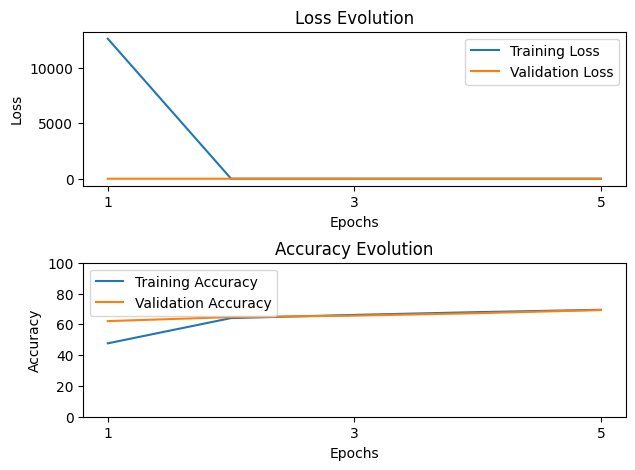

In [22]:
# Graficar la evolución de la pérdida y la precisión
plt.figure(figsize=(7, 5))

plt.subplot(2, 1, 1)
plt.plot(range(1, params['num_epochs'] + 1), train_losses, label='Training Loss')
plt.plot(range(1, params['num_epochs'] + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Evolution')
plt.legend()
plt.xticks(range(1, params['num_epochs'] + 1, 2))  # Mostrar solo enteros en el eje x


plt.subplot(2, 1, 2)
plt.plot(range(1, params['num_epochs'] + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, params['num_epochs'] + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Evolution')
plt.legend()
plt.ylim(0, 100)  # Establecer los límites del eje y entre 0 y 100%
plt.xticks(range(1, params['num_epochs'] + 1, 2))  # Mostrar solo enteros en el eje x

plt.subplots_adjust(hspace=0.5)

plt.show()

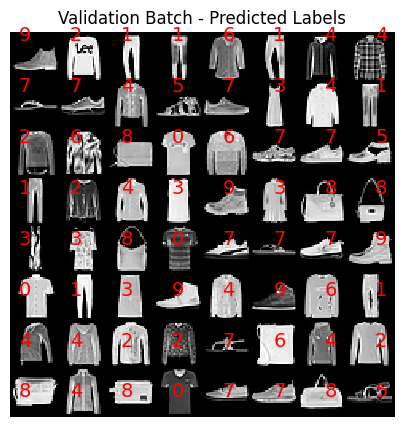

In [23]:
# Set the model to evaluation mode
model_advanced.eval()

# Make predictions
with torch.no_grad():
    val_images = val_images.to(device); val_labels = val_labels.to(device)
    outputs = model_advanced(val_images)
    val_images = val_images.cpu()
    _, predicted = torch.max(outputs.cpu(), 1)

# Create a grid of images
val_img_grid = make_grid(val_images)

# Plot the grid with predicted labels
plt.figure(figsize=(5, 5))
plt.imshow(val_img_grid.permute(1, 2, 0), interpolation='nearest')
plt.axis('off')
plt.title('Validation Batch - Predicted Labels')

# Annotate the images with predicted labels
for i in range(val_images.size(0)):
    plt.text(i % 8 * 32 + 5, i // 8 * 32 + 5, str(predicted[i].item()), color='red', fontsize=14)

plt.show()

In [25]:
archive_name = "model_finetuned_advanced.safetensors"
saving_path = os.path.join (MODELS_DIR, archive_name)
save_file(model_advanced.state_dict(), saving_path)